# Stackoverflow Developer Survey 2019: Data Scientist Profile

## Outline:
1. Read in data
2. Subset data scientists 
3. Missing data
4. Data scientist profile
5. Conclusions

In [1]:
import pandas as pd
import numpy as np

In [2]:
!python --version

Python 3.6.9 :: Anaconda, Inc.


In [3]:
!jupyter-notebook --version

6.0.1


In [4]:
print(f'Pandas version: {pd.__version__}, Numpy version: {np.__version__}')

Pandas version: 0.25.1, Numpy version: 1.16.4


## I. Read in data

We will read in the survey data using Pandas read_csv function. Fortunately, the dataset seems to be very well organized so this is pretty straight forward to do.

In [71]:
df = pd.read_csv('../data/survey_results_public.zip', compression='zip')
df.head(2)

,Respondent,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,Student,EdLevel,UndergradMajor,...,WelcomeChange,SONewContent,Age,Gender,Trans,Sexuality,Ethnicity,Dependents,SurveyLength,SurveyEase
0,1,I am a student who is learning to code,Yes,Never,The quality of OSS and closed source software ...,"Not employed, and not looking for work",United Kingdom,No,Primary/elementary school,NaN,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,14.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
1,2,I am a student who is learning to code,No,Less than once per year,The quality of OSS and closed source software ...,"Not employed, but looking for work",Bosnia and Herzegovina,"Yes, full-time","Secondary school (e.g. American high school, G...",NaN,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,19.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult


In [72]:
df.shape

(88883, 85)

In [7]:
df.dtypes

Respondent       int64
MainBranch      object
Hobbyist        object
OpenSourcer     object
OpenSource      object
                 ...  
Sexuality       object
Ethnicity       object
Dependents      object
SurveyLength    object
SurveyEase      object
Length: 85, dtype: object

The survey dataset contains 88,883 rows and 85 columns, with 6 numerical columns and 79 'object' columns. When Pandas returns a 'object' type usually means that the column (or 'Series' in Pandas jargon) contains strings or a mix of data types. Pandas does not allow for multiple data types in a Series, which is preciselly why Pandas upcast such columns to the type 'object', which is the more general data type in Pandas. The 'mixing' usually comes from combining strings cases with 'NaN' cases, and 'NaN' values tuns out to be 'float' data types. Now let's find the variable that will help us to extract the Data Scientist from the survey.

In [8]:
df.columns

Index(['Respondent', 'MainBranch', 'Hobbyist', 'OpenSourcer', 'OpenSource',
       'Employment', 'Country', 'Student', 'EdLevel', 'UndergradMajor',
       'EduOther', 'OrgSize', 'DevType', 'YearsCode', 'Age1stCode',
       'YearsCodePro', 'CareerSat', 'JobSat', 'MgrIdiot', 'MgrMoney',
       'MgrWant', 'JobSeek', 'LastHireDate', 'LastInt', 'FizzBuzz',
       'JobFactors', 'ResumeUpdate', 'CurrencySymbol', 'CurrencyDesc',
       'CompTotal', 'CompFreq', 'ConvertedComp', 'WorkWeekHrs', 'WorkPlan',
       'WorkChallenge', 'WorkRemote', 'WorkLoc', 'ImpSyn', 'CodeRev',
       'CodeRevHrs', 'UnitTests', 'PurchaseHow', 'PurchaseWhat',
       'LanguageWorkedWith', 'LanguageDesireNextYear', 'DatabaseWorkedWith',
       'DatabaseDesireNextYear', 'PlatformWorkedWith',
       'PlatformDesireNextYear', 'WebFrameWorkedWith',
       'WebFrameDesireNextYear', 'MiscTechWorkedWith',
       'MiscTechDesireNextYear', 'DevEnviron', 'OpSys', 'Containers',
       'BlockchainOrg', 'BlockchainIs', 'BetterLife'

A quick glance to the column names suggest that 'Employment' or maybe 'DevType' may contain what we are looking for. Let's subset and print out those columns. 

In [9]:
df[['Employment', 'DevType']][0:5]

,Employment,DevType
0,"Not employed, and not looking for work",NaN
1,"Not employed, but looking for work","Developer, desktop or enterprise applications;..."
2,Employed full-time,"Designer;Developer, back-end;Developer, front-..."
3,Employed full-time,"Developer, full-stack"
4,Employed full-time,"Academic researcher;Developer, desktop or ente..."


As we can see, 'Devtype' contains what we are looking for. One important issue with this dataset, it is that most columns are indeed strings. In survey research, it is usually considered bad practice to encode data as text. Ideally, we want to have numerical identifiers for each category within a column, and a dictionary of identifier to identify values, which makes subsetting data extremely convinient. This is not the case here, so we will need to do some data gymnastics to filter our what we are looking for.

## Subsetting Data Scientist Data

There are multiple ways to approach the data filtering. If you are into text analysis or natural language processing, you may be a regular expression wizard, and solve this very quickly. I'm not, and I have a particular distaste for memorizing regular expressions syntax which I happen to think is one of the most useful, yet, ugly abominations ever invented. Therefore, I'll take advantage of a mix of pure Python to get the job done. This is what I'm going to do:

1. Create a list of keyword to search within each string
2. Cast the DevType column into a list of strings
3. Search within each string in the list the keywords in my 'search' list
4. Return 'True' if ANY of the keywords is the string, and 'False' otherwise
5. Use the resulting boolean array of 'True' and 'False' values to filter the original dataframe

The way in which step 5 works, is simple: Pandas will retain the rows where 'True' is passed, and drop the rest.

Note that there isn't such a thing as a universally accepted way to define who is a data scientist, so feel free to define your own keywords for search. For instance, I decided to not add Database administrator, which tend to overlap with back-end software engineers.

In [10]:
search = ['data scientist', 'data analyst', 'business analyst', 'machine learning'] # keywords to be searched
filter = list(df.DevType.astype(str)) # list to be filtered
mask = [True if search[0] in x.lower() or search[1] in x.lower() or search[2] in x.lower() or search[3] in x.lower() else False for x in filter] # boolean mask
df_mask = df[mask]
df_ds = df_mask.copy() # we create a new copy to avoid changing the raw data
df_ds.shape

(10675, 85)

In [11]:
df_ds.DevType.head(10)

5     Data or business analyst;Data scientist or mac...
9     Data or business analyst;Data scientist or mac...
11    Data or business analyst;Data scientist or mac...
12    Data or business analyst;Database administrato...
17                             Data or business analyst
21    Data or business analyst;Designer;Developer, b...
32    Academic researcher;Data scientist or machine ...
41    Academic researcher;Data or business analyst;D...
50       Data or business analyst;Developer, full-stack
58    Data or business analyst;Database administrato...
Name: DevType, dtype: object

We obtained a dataframe with 10,675 rows where people mentioned **at least one** of our keywords. At this point we can eyeball that **1/8 or ~12%** of the respondent identify themselves as Data Scientist, which looks a pretty decent sample size for our analysis.

## II. Missing Data

Cheking for missing values is standard practice, particularly when the goal is hypothesis testing, machine learning, or predictive modeling. Some people may prefer to do this only under the aforementioned circumstances, but I consider that this is important for exploratory data analysis as well. If you find patterns of missing data, for instance, by gender, data might offer a misleading representation of the population. Pandas makes this very simple

In [12]:
df_ds.isnull().sum().sort_values(ascending=True).plot(kind='barh', figsize=(10, 20));

The barplot shows the number of rows with missing values. We see that *CodRevHrs* has almost 5000 missing values, which is around 50% of the data. Only 5 features have zero missing values. In general, it seems to be a lot of missing values in most variables, which calls for precaution when interpreting results from this survey.  

The plot works in the following manner: 
- ```.isnull()``` returns a boolean for each cell within each feature. *True* when there is a missing value, *False* otherwise
- ```.sum()``` sums over all the True values within a feature. The trick is that booleans in Python technically are numeric types with 1 for *True* and 0 for *False*
- ```.sort_values()``` sort values from larger to smaller
- ```.plot(kind='barh', figsize=(10, 20))``` returns an horizontal bar plot

As note about plots in Python: I often read/hear R users mentioning that ploting in Python is harder. I think that such impression can be a product of two things: first, comparing Matplotlib and ggplot2. Matplotlib is verbose and uses a different philosophy than ggplot2, which makes it unintuitive for R users; second, simpler ways to make plots (like the out-of-the-box functionality of Pandas) are often unknown; Python is an object oriented language, which is an strange thing to get your head around when you are use to functional oriented languages like R. Personally, the fact that Python is an object oriented language that makes possible to make sequencial method calls (as in this plot), makes Python extremely convinient for simple tasks like visualizing missing values.

## III. Data Scientist Profile

Our goal is to characterize Data Scientist profiles by roughly reproducing the StackOverflow results for all Developers in 2019. You can find the 2019 results here https://insights.stackoverflow.com/survey/2019#overview 

Most features in the survey are text. Text makes data exploration a bit complicated, because it requires extra data wrangling before ploting. We will create a generic function to plot bar-plots using Pandas default functionality. 

This is how the function works:
- Selects the series to be ploted
- Counts the frequency by group 
- Computes the percentage from the total with a lambda function
- Generates the plot

Pandas will plot the columns ordered by their magnitud. This is useful in some cases but ilogical in others, therefore, we need to pass a list with the desired order as an argument to the function signature to provide our desired ordering. 

An additional get_percent function will allows to get the actual numbers for the series.

In [13]:
def bar_plot_percent(series: str, kind: str, title: str, order=None, df=df_ds):
    return df[series].value_counts().apply(lambda x: np.round((x/len(df))*100, decimals=2)).reindex(order).plot(kind=kind, title=title);

In [14]:
def get_percent(series: str, df=df_ds):
    return df[series].value_counts().apply(lambda x: np.round((x/len(df))*100, decimals=2))

### Data Scientist Role

#### Contributing to Open Source

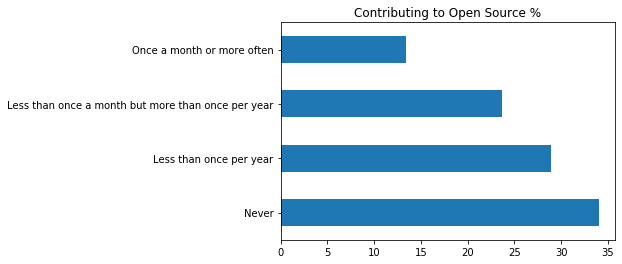

In [15]:
bar_plot_percent('OpenSourcer', 'barh', 'Contributing to Open Source %');

#### Coding as a Hobby

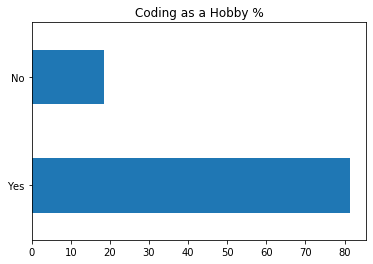

In [16]:
bar_plot_percent('Hobbyist', 'barh', 'Coding as a Hobby %');

### Experience

#### Years Since Learning to Code

Here we have an interesting problem. There is a mix of intergers and strings types. Casting everything to numerical won't work, unless we handle the non-numerical values firts. I'll map *'Less than 1 year'* to 1 and 'More than 50 years' to 51.This will work for us since we will partition the data into broader groups later.

In [17]:
df_ds.YearsCode.unique()

array(['13', '12', '5', '17', '10', '35', '6', '8', '4', '25', '1', '30',
       '3', '7', '41', '16', '20', '22', '18', '23', '21', '19', '14',
       '32', '27', '2', '9', '15', '40', '33', '11', '26',
       'Less than 1 year', '24', '37', nan, '28', '34', '29', '36', '45',
       '46', '31', '38', 'More than 50 years', '48', '39', '42', '50',
       '47', '43', '44', '49'], dtype=object)

In [18]:
df_ds.YearsCode.replace({'Less than 1 year': 1, 'More than 50 years': 51}, inplace=True)

In [19]:
df_ds.YearsCode = df_ds.YearsCode.astype('float64')

In [20]:
conditions_years = [
    (df_ds['YearsCode'] < 5),
    (df_ds['YearsCode'] >= 5) & (df_ds['YearsCode'] <= 9),
    (df_ds['YearsCode'] >= 10) & (df_ds['YearsCode'] <= 14),
    (df_ds['YearsCode'] >= 15) & (df_ds['YearsCode'] <= 19),
    (df_ds['YearsCode'] >= 20) & (df_ds['YearsCode'] <= 24),
    (df_ds['YearsCode'] >= 25) & (df_ds['YearsCode'] <= 29),
    (df_ds['YearsCode'] >= 30) & (df_ds['YearsCode'] <= 34),
    (df_ds['YearsCode'] >= 35) & (df_ds['YearsCode'] <= 39),
    (df_ds['YearsCode'] >= 40) & (df_ds['YearsCode'] <= 44),
    (df_ds['YearsCode'] >= 45) & (df_ds['YearsCode'] <= 49),
    (df_ds['YearsCode'] >= 50)
    ]

categories_years = [
    '5 years or less', '5 to 9 years', '10 to 14 years', '15 to 19 years',
    '20 to 24 years', '25 to 29 years', '30 to 34 years', '35 to 39 years', 
    '40 to 44 years', '45 to 49 years', '50 years or more'
    ]

df_ds['YearsCodeR'] = np.select(conditions_years, categories_years)

A bunch of zeros will be generated, so we will replace those witn NaN values before ploting

In [21]:
df_ds.YearsCodeR.replace({'0': np.nan}, inplace=True)

We then obtain this results

In [22]:
df_ds.YearsCodeR.value_counts()

5 to 9 years        3016
10 to 14 years      2038
5 years or less     1974
15 to 19 years      1198
20 to 24 years       895
30 to 34 years       480
25 to 29 years       477
35 to 39 years       335
40 to 44 years       144
45 to 49 years        42
50 years or more      27
Name: YearsCodeR, dtype: int64

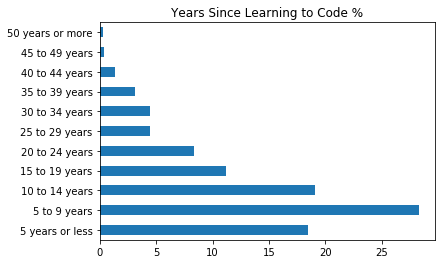

In [23]:
bar_plot_percent('YearsCodeR', 'barh', 'Years Since Learning to Code %', order=categories_years);

#### Years Coding Professionally

Years coding professionlly has the same issues found in Years Coding, so we will repeat the steps.

In [24]:
df_ds.YearsCodePro.unique()

array(['3', '10', nan, '8', '18', '5', '13', '1', '25', '2', '6', '4',
       '35', '11', '7', '20', '9', '16', '21', '30', 'Less than 1 year',
       '17', '15', '19', '37', '12', '23', '40', '22', '29', '24', '45',
       '32', '14', '43', '34', 'More than 50 years', '26', '33', '44',
       '36', '28', '27', '31', '50', '42', '39', '38', '41', '46', '47'],
      dtype=object)

In [25]:
df_ds.YearsCodePro.replace({'Less than 1 year': 1, 'More than 50 years': 51}, inplace=True)

In [26]:
df_ds.YearsCodePro = df_ds.YearsCodePro.astype('float64')

In [27]:
df_ds['YearsCodeProR'] = np.select(conditions_years, categories_years)

In [28]:
df_ds.YearsCodeProR.replace({'0': np.nan}, inplace=True)

In [29]:
df_ds.YearsCodeProR.value_counts()

5 to 9 years        3016
10 to 14 years      2038
5 years or less     1974
15 to 19 years      1198
20 to 24 years       895
30 to 34 years       480
25 to 29 years       477
35 to 39 years       335
40 to 44 years       144
45 to 49 years        42
50 years or more      27
Name: YearsCodeProR, dtype: int64

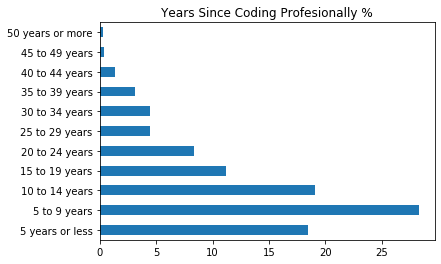

In [30]:
bar_plot_percent('YearsCodeProR', 'barh', 'Years Since Coding Profesionally %', order=categories_years);

#### Writing That First Line of Code

Here we have the same problems as in the previous cases, so we will repeat the steps again. One caveat is that now we need to redefine age ranges (i.e., conditions andcategories)

In [31]:
df_ds.Age1stCode.unique()

array(['15', '20', '16', '11', '18', '12', '9', '14', '7', nan, '10',
       '17', '19', '13', '33', '22', '30', 'Younger than 5 years', '24',
       '8', '21', '26', '5', '23', '25', '6', '29', '31', '28', '34',
       '32', '35', '27', 'Older than 85', '50', '43', '56', '45', '36',
       '79', '39', '40', '42', '37', '65', '38', '41', '51', '61', '44'],
      dtype=object)

In [32]:
df_ds.Age1stCode.replace({'Younger than 5 years': 4, 'Older than 85': 86}, inplace=True)

In [33]:
df_ds.Age1stCode = df_ds.Age1stCode.astype('float64')

In [34]:
conditions_age = [
    (df_ds['Age1stCode'] < 10),
    (df_ds['Age1stCode'] >= 10) & (df_ds['Age1stCode'] <= 11),
    (df_ds['Age1stCode'] >= 12) & (df_ds['Age1stCode'] <= 13),
    (df_ds['Age1stCode'] >= 14) & (df_ds['Age1stCode'] <= 15),
    (df_ds['Age1stCode'] >= 16) & (df_ds['Age1stCode'] <= 17),
    (df_ds['Age1stCode'] >= 18) & (df_ds['Age1stCode'] <= 19),
    (df_ds['Age1stCode'] >= 20) & (df_ds['Age1stCode'] <= 21),
    (df_ds['Age1stCode'] >= 22) & (df_ds['Age1stCode'] <= 23),
    (df_ds['Age1stCode'] >= 24) & (df_ds['Age1stCode'] <= 25),
    (df_ds['Age1stCode'] >= 26) & (df_ds['Age1stCode'] <= 27),
    (df_ds['Age1stCode'] >= 28) & (df_ds['Age1stCode'] <= 29),
    (df_ds['Age1stCode'] >= 50)
    ]

categories_age = [
    'Younger than 10 years', '10 to 11 years old', '12 to 13 years old', '14 to 15 years old',
    '16 to 17 years old', '18 to 19 years old', '20 to 21 years old', '22 to 23 years old', 
    '24 to 25 years old', '26 to 27 years old', '28 to 29 years old', '30 years old or older'
    ]

df_ds['Age1stCodeR'] = np.select(conditions_age, categories_age)

In [35]:
df_ds.Age1stCodeR.replace({'0': np.nan}, inplace=True)

In [36]:
df_ds.Age1stCodeR.value_counts()

14 to 15 years old       1932
12 to 13 years old       1638
16 to 17 years old       1603
18 to 19 years old       1509
Younger than 10 years    1093
10 to 11 years old       1030
20 to 21 years old        739
22 to 23 years old        378
24 to 25 years old        253
26 to 27 years old        117
28 to 29 years old         90
30 years old or older      16
Name: Age1stCodeR, dtype: int64

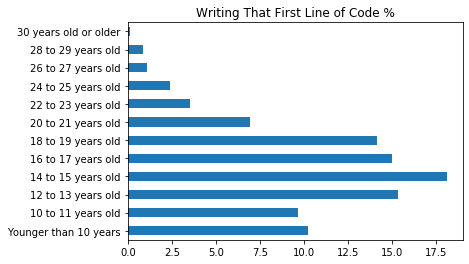

In [37]:
bar_plot_percent('Age1stCodeR', 'barh', 'Writing That First Line of Code %', order=categories_age);

###  Education

#### How Many Developers are Students?

In [38]:
df_ds.Student.unique()

array(['No', 'Yes, full-time', 'Yes, part-time', nan], dtype=object)

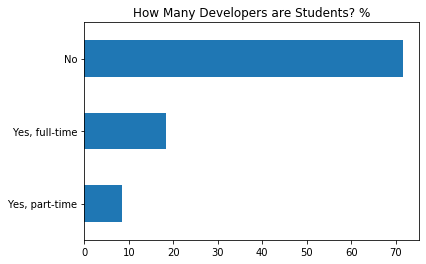

In [39]:
order_students = ['Yes, part-time', 'Yes, full-time', 'No']
bar_plot_percent('Student', 'barh', 'How Many Developers are Students? %', order=order_students);

#### Educational Attainment

In [40]:
df_ds.EdLevel.unique()

array(['Bachelor’s degree (BA, BS, B.Eng., etc.)',
       'Master’s degree (MA, MS, M.Eng., MBA, etc.)',
       'Some college/university study without earning a degree',
       'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
       'Associate degree', 'Other doctoral degree (Ph.D, Ed.D., etc.)',
       'Professional degree (JD, MD, etc.)', 'Primary/elementary school',
       nan, 'I never completed any formal education'], dtype=object)

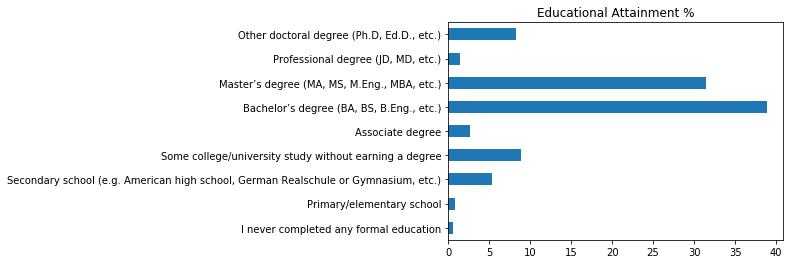

In [41]:
order_ed = [
    'I never completed any formal education', 'Primary/elementary school',
    'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
    'Some college/university study without earning a degree',
    'Associate degree',
    'Bachelor’s degree (BA, BS, B.Eng., etc.)',
    'Master’s degree (MA, MS, M.Eng., MBA, etc.)',
    'Professional degree (JD, MD, etc.)',
    'Other doctoral degree (Ph.D, Ed.D., etc.)'
    ]
bar_plot_percent('EdLevel', 'barh', 'Educational Attainment %', order=order_ed);

#### Undergraduate Major

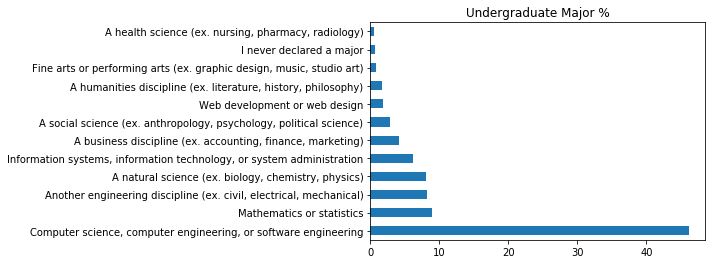

In [42]:
bar_plot_percent('UndergradMajor', 'barh', 'Undergraduate Major %');

In [43]:
get_percent('UndergradMajor')

Computer science, computer engineering, or software engineering          46.22
Mathematics or statistics                                                 8.92
Another engineering discipline (ex. civil, electrical, mechanical)        8.16
A natural science (ex. biology, chemistry, physics)                       8.02
Information systems, information technology, or system administration     6.15
A business discipline (ex. accounting, finance, marketing)                4.12
A social science (ex. anthropology, psychology, political science)        2.88
Web development or web design                                             1.85
A humanities discipline (ex. literature, history, philosophy)             1.63
Fine arts or performing arts (ex. graphic design, music, studio art)      0.86
I never declared a major                                                  0.70
A health science (ex. nursing, pharmacy, radiology)                       0.52
Name: UndergradMajor, dtype: float64

#### Other Types of Education

The Other Types of Education feature is a string of multiple answers join by ';'. This is a bit tricky to plot, and there many ways to approch this. My approach will be:

- Declare a list of strings, with the categories to be counted
- Declare a empty dictionary to count occurrences of each category
- Loop over each category, applying a lambda function to split each string by ';', and get the total count for each category. 
- Re-asign to the empty dictionary, and make it into a pandas dataframe

In [44]:
df_ds.EduOther.head()

5     Taken an online course in programming or softw...
9                                                   NaN
11    Taken an online course in programming or softw...
12    Taken an online course in programming or softw...
17    Taken an online course in programming or softw...
Name: EduOther, dtype: object

In [45]:
c = [
    'Taught yourself a new language, framework, or tool without taking a formal course',
    'Taken an online course in programming or software development (e.g. a MOOC)',
    'Contributed to open source software',
    'Received on-the-job training in software development',
    'Participated in a hackathon',
    'Participated in online coding competitions (e.g. HackerRank, CodeChef, TopCoder)',
    'Taken a part-time in-person course in programming or software development',
    'Participated in a full-time developer training program or bootcamp',
    'Completed an industry certification program (e.g. MCPD)'
]

tmp = {}

In [46]:
for s in c:
    tmp[s] = (df_ds.EduOther.apply(lambda x: (str(x).split(';')).count(s))).sum()

In [47]:
ed_df = pd.DataFrame.from_dict(tmp, orient='index')

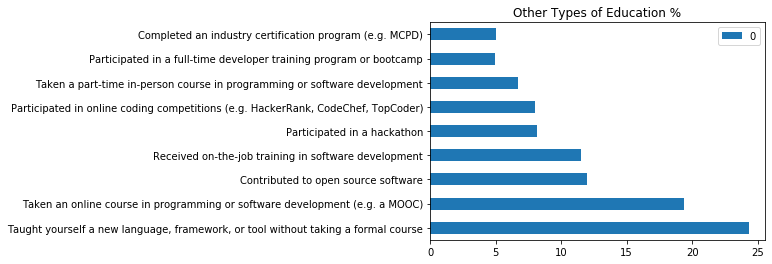

In [48]:
ed_df.apply(lambda x: np.round((x/ed_df.sum()[0])*100, decimals=2)).plot(kind='barh', title='Other Types of Education %');

In [49]:
ed_df.apply(lambda x: np.round((x/ed_df.sum()[0])*100, decimals=2))

,0
"Taught yourself a new language, framework, or tool without taking a formal course",24.32
Taken an online course in programming or software development (e.g. a MOOC),19.40
Contributed to open source software,11.97
Received on-the-job training in software development,11.48
Participated in a hackathon,8.15
"Participated in online coding competitions (e.g. HackerRank, CodeChef, TopCoder)",7.99
Taken a part-time in-person course in programming or software development,6.68
Participated in a full-time developer training program or bootcamp,4.98
Completed an industry certification program (e.g. MCPD),5.03


### Demographics

#### Race and Ethnicity

Race and Ethnicity is particularly complicated, since people may identify as belonging to multiple groups. By inspecting the data, looks like people were **allowed to select multiple groups**. This is, of course, the best choice in terms of accuracy in identity representation, but makes analysis almost imposible without making hard and arbitrary choices regarding how to group people into buckets. **"Can you just categorize as multiracial/multiethnic to people that selected multiple options"?** Absolutely. This would have been a great option. Unfortunately, people did selected multiracial and *at the same time* other optins like Biracial, White, Middle Estern, etc. In fact, there are *123 unique combinatios* of races/ethnicities in the survey. If we lump together as *multiracial* to people that chose multiple groups, Black or of African descent will get nulified as a group. If we apply the same logic applied to 'Other types of education' were will be double counting responses: if I selected Latino and Biracial, my answer will contribute to the total of both responses. 

What to do? I'll go with the double counting. I think this option respect people choices (to some degree) and makes our visualization cleaner.

In [50]:
c = [
    'White or of European descent',
    'South Asian',
    'Hispanic or Latino/Latina',
    'East Asian',
    'Middle Eastern',
    'Black or of African descent',
    'Multiracial',
    'Biracial',
    'Native American, Pacific Islander, or Indigenous Australian'
    ]

tmp = {}

In [51]:
for s in c:
    tmp[s] = (df_ds.Ethnicity.apply(lambda x: (str(x).split(';')).count(s))).sum()

In [52]:
et_df = pd.DataFrame.from_dict(tmp, orient='index')

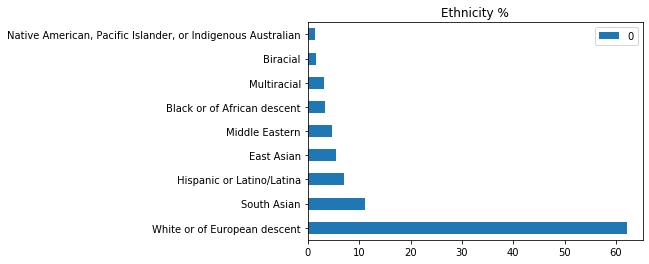

In [53]:
et_df.apply(lambda x: np.round((x/et_df.sum()[0])*100, decimals=2)).plot(kind='barh', title='Ethnicity %');

In [54]:
et_df.apply(lambda x: np.round((x/et_df.sum()[0])*100, decimals=2))

,0
White or of European descent,62.07
South Asian,11.10
Hispanic or Latino/Latina,7.06
East Asian,5.40
Middle Eastern,4.74
Black or of African descent,3.43
Multiracial,3.09
Biracial,1.68
"Native American, Pacific Islander, or Indigenous Australian",1.43


#### Gender

Gender is as complex as ethnicity.Again, people selected multiple choices. Fortunately, this time there are only 7 different unique sets of gender choices, so we can go an plot them as they are.

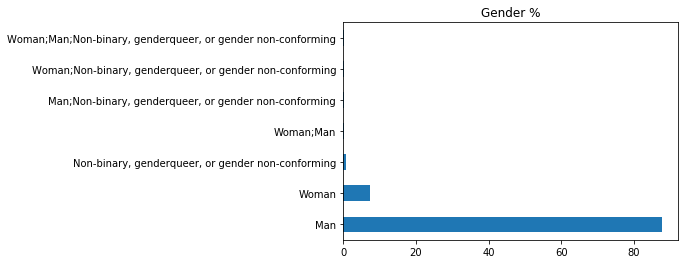

In [55]:
bar_plot_percent('Gender', 'barh', 'Gender %');

In [56]:
get_percent('Gender')

Man                                                            87.69
Woman                                                           7.37
Non-binary, genderqueer, or gender non-conforming               0.75
Woman;Man                                                       0.29
Man;Non-binary, genderqueer, or gender non-conforming           0.24
Woman;Non-binary, genderqueer, or gender non-conforming         0.17
Woman;Man;Non-binary, genderqueer, or gender non-conforming     0.14
Name: Gender, dtype: float64

#### Experience and Gender

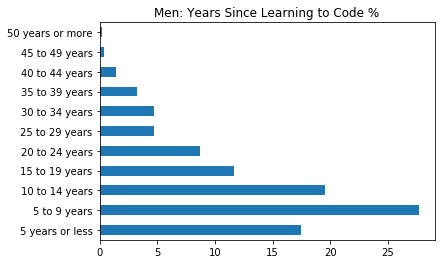

In [57]:
bar_plot_percent('YearsCodeR', 'barh', 'Men: Years Since Learning to Code %', order=categories_years, df=df_ds[df_ds['Gender'] == 'Man']);

In [58]:
get_percent('YearsCodeR', df=df_ds[df_ds['Gender'] == 'Man'])

5 to 9 years        27.64
10 to 14 years      19.52
5 years or less     17.47
15 to 19 years      11.64
20 to 24 years       8.67
25 to 29 years       4.70
30 to 34 years       4.70
35 to 39 years       3.26
40 to 44 years       1.44
45 to 49 years       0.41
50 years or more     0.24
Name: YearsCodeR, dtype: float64

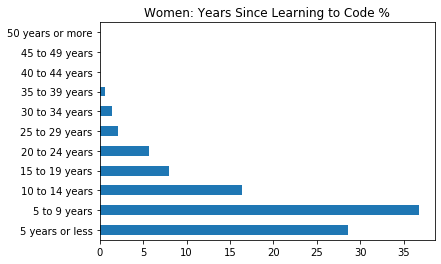

In [59]:
bar_plot_percent('YearsCodeR', 'barh', 'Women: Years Since Learning to Code %', order=categories_years, df=df_ds[df_ds['Gender'] == 'Woman']);

In [60]:
get_percent('YearsCodeR', df=df_ds[df_ds['Gender'] == 'Woman'])

5 to 9 years       36.72
5 years or less    28.59
10 to 14 years     16.39
15 to 19 years      8.01
20 to 24 years      5.72
25 to 29 years      2.16
30 to 34 years      1.40
35 to 39 years      0.64
Name: YearsCodeR, dtype: float64

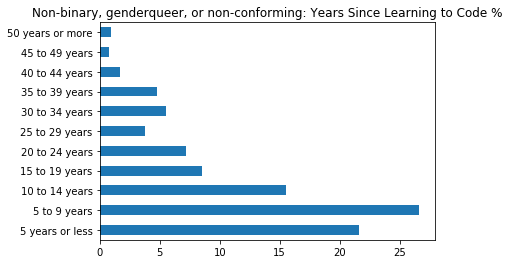

In [61]:
bar_plot_percent('YearsCodeR', 'barh', 'Non-binary, genderqueer, or non-conforming: Years Since Learning to Code %', order=categories_years, df=df_ds[(df_ds['Gender'] != "Man") & (df_ds['Gender'] != "Woman")]);

In [62]:
get_percent('YearsCodeR', df_ds[(df_ds['Gender'] != "Man") & (df_ds['Gender'] != "Woman")])

5 to 9 years        26.57
5 years or less     21.63
10 to 14 years      15.56
15 to 19 years       8.54
20 to 24 years       7.21
30 to 34 years       5.50
35 to 39 years       4.74
25 to 29 years       3.80
40 to 44 years       1.71
50 years or more     0.95
45 to 49 years       0.76
Name: YearsCodeR, dtype: float64

#### Sexual Orientation

In [63]:
df_ds.Sexuality.unique()

array(['Straight / Heterosexual', nan, 'Bisexual', 'Gay or Lesbian',
       'Bisexual;Straight / Heterosexual',
       'Bisexual;Gay or Lesbian;Straight / Heterosexual',
       'Bisexual;Gay or Lesbian',
       'Gay or Lesbian;Straight / Heterosexual'], dtype=object)

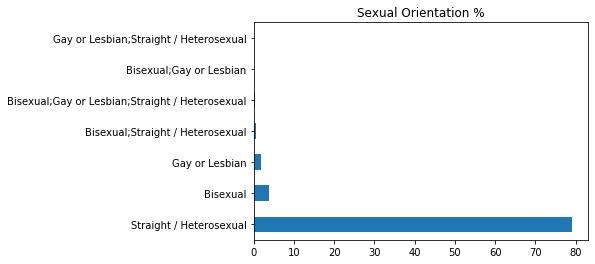

In [64]:
bar_plot_percent('Sexuality', 'barh', 'Sexual Orientation %');

In [65]:
get_percent('Sexuality')

Straight / Heterosexual                            79.22
Bisexual                                            3.86
Gay or Lesbian                                      1.90
Bisexual;Straight / Heterosexual                    0.67
Bisexual;Gay or Lesbian;Straight / Heterosexual     0.33
Bisexual;Gay or Lesbian                             0.17
Gay or Lesbian;Straight / Heterosexual              0.06
Name: Sexuality, dtype: float64

#### Disability Status
Unfortunately, this feature is absent in the dataset

#### Age

In [66]:
conditions_a = [
    (df_ds['Age'] < 15),
    (df_ds['Age'] >= 15) & (df_ds['Age'] <= 19),
    (df_ds['Age'] >= 20) & (df_ds['Age'] <= 24),
    (df_ds['Age'] >= 25) & (df_ds['Age'] <= 29),
    (df_ds['Age'] >= 30) & (df_ds['Age'] <= 34),
    (df_ds['Age'] >= 35) & (df_ds['Age'] <= 39),
    (df_ds['Age'] >= 40) & (df_ds['Age'] <= 44),
    (df_ds['Age'] >= 45) & (df_ds['Age'] <= 49),
    (df_ds['Age'] >= 50) & (df_ds['Age'] <= 54),
    (df_ds['Age'] >= 55) & (df_ds['Age'] <= 59),
    (df_ds['Age1stCode'] >= 60)
    ]

categories_a = [
    'Younger than 15 years', '15 to 19 years', '20 to 24 years', 
    '25 to 29 years','30 to 34 years', '35 to 39 years', '40 to 44 years', 
    '45 to 49 years', '50 to 54 years','55 to 59 years', '60 years and older'
    ]

df_ds['AgeR'] = np.select(conditions_a, categories_a)

In [67]:
df_ds.AgeR.replace({'0': np.nan}, inplace=True)

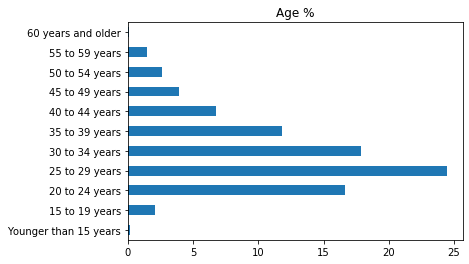

In [68]:
bar_plot_percent('AgeR', 'barh', 'Age %', order=categories_a);

#### Average Age by Country

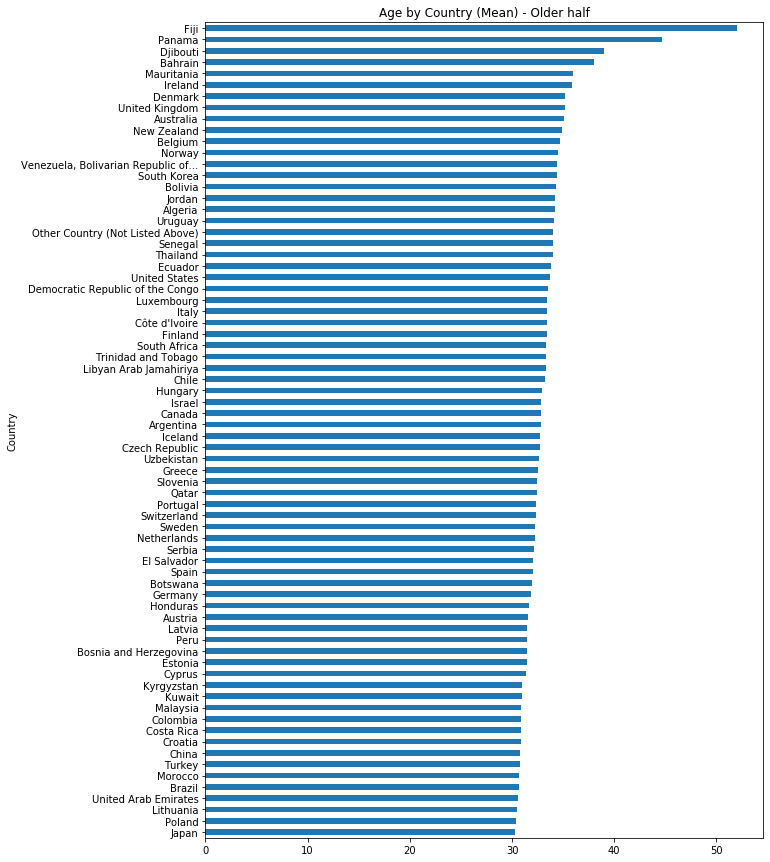

In [69]:
half = int(len(df_ds.Country.unique())/2) # to select half of the countries
mean_country_mask = df_ds.groupby('Country')['Age'].mean() > 0 # filter out countries with mean 0
df_ds.groupby('Country')['Age'].mean()[mean_country_mask].sort_values().tail(half).plot(kind='barh', figsize=(10, 15), title= 'Age by Country (Mean) - Older half');

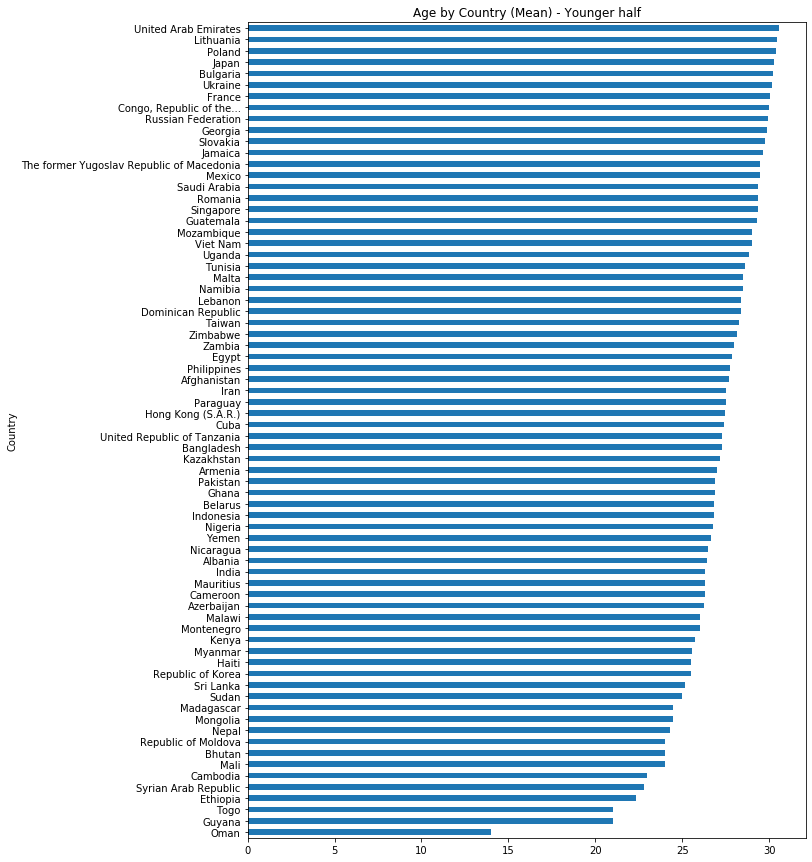

In [70]:
df_ds.groupby('Country')['Age'].mean()[mean_country_mask].sort_values().head(half).plot(kind='barh', figsize=(10, 15), title= 'Age by Country (Mean) - Younger half');

#### Average Years of Coding Experience by Country